### <center>San Jose State University<br>Department of Applied Data Science<br><br>**DATA 225<br>Database Systems for Analytics**<br><br>Spring 2023<br>Instructor: Ron Mak<br><br>**Checkpoint Exam #2**<br>October 30<br><br>Maximum 100 points maximum<br>You have 100 minutes<br><br>***INDIVIDUAL WORK ONLY!***<br>The Academic Integrity Policy will be <u>strictly enforced</u>.<br><br>SOLUTIONS</center>

# PROBLEM 1
#### [10 points] It is possible to download data from a database and use Python to generate a horizontal bar chart. For example, here is a chart of the percentages of Titanic passengers in each passenger class:
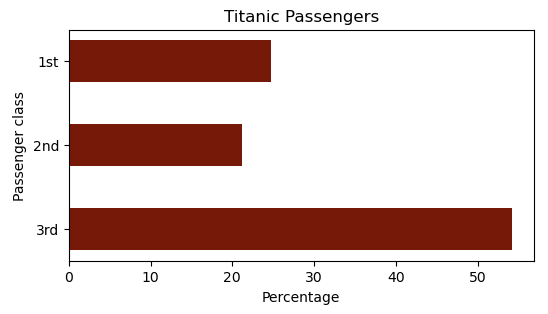
#### But downloading may not be an option for a large dataset. Instead, you can use SQL to generate a crude horizontal bar chart on the server side and only download the chart. The downloaded data might look like this as Python tuples:
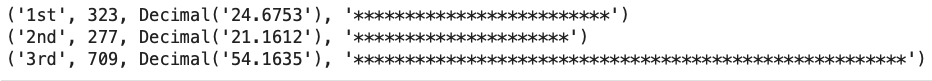

In [1]:
from pandas import DataFrame
from DATA225utils import make_connection, dataframe_query

In [2]:
conn = make_connection(config_file = 'titanic.ini')
cursor = conn.cursor()

In [3]:
cursor.execute('SET @total = (SELECT COUNT(*) FROM passengers)')

sql = ( """
        SELECT @class := class, COUNT(*), 
               @pct   := (SELECT 100*COUNT(*)/@total
                          FROM passengers
                          WHERE class = @class),
               REPEAT('*', @pct)
        FROM passengers
        GROUP BY class
        ORDER BY class
        """
      )

cursor.execute(sql)
rows = cursor.fetchall()

for row in rows:
    print(row)

('1st', 323, Decimal('24.6753'), '*************************')
('2nd', 277, Decimal('21.1612'), '*********************')
('3rd', 709, Decimal('54.1635'), '******************************************************')


In [4]:
cursor.close()
conn.close()

# PROBLEM 2
#### [30 points] The example SQL code given in class to perform linear regression with one independent variable used local `@` variables. However, the regression examples with two and three independent variables did not use local variables. Instead, they used views to perform the intermediate calculations.
#### The formula to calculate the Pearson correlation coefficient *r* is
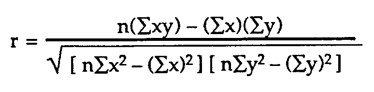
#### Write SQL code to access the **sizes** tables of the **babies** database and compute the Pearson correlation coefficient between the babies' weights (in kg) and their lengths (in cm). Use the formula above. It doesn't matter which is *x* and which is *y*. **Do not use local variables but use views instead as necessary.** Query and display the value of the calculated coefficient.

In [5]:
conn = make_connection(config_file = 'babies.ini')
cursor = conn.cursor()

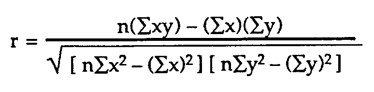

In [6]:
cursor.execute('DROP VIEW IF EXISTS base1')

sql = ( """
        CREATE VIEW base1 AS
            SELECT
                COUNT(*)                 AS n,
                SUM(weight_kg)           AS sum_x,
                SUM(length_cm)           AS sum_y,
                SUM(weight_kg*weight_kg) AS sum_xx,
                SUM(length_cm*length_cm) AS sum_yy,
                SUM(weight_kg*length_cm) AS sum_xy
            FROM sizes;
        """
      )

cursor.execute(sql);

In [7]:
cursor.execute('DROP VIEW IF EXISTS base2')

sql = ( """
        CREATE VIEW base2 AS
            SELECT
                n*sum_xx - sum_x*sum_x AS factor1,
                n*sum_yy - sum_y*sum_y AS factor2
            FROM base1;        
            """
      )

cursor.execute(sql)

In [8]:
sql = ( """
        SELECT (n*sum_xy - sum_x*sum_y)
             / SQRT(factor1*factor2) AS pearson
        FROM base1, base2        
        """
      )

_, df = dataframe_query(conn, sql)
df

pearson
0  0.470177

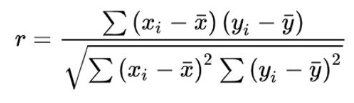

In [9]:
cursor.execute('DROP VIEW IF EXISTS base3')

sql = ( """
        CREATE VIEW base3 AS
            SELECT AVG(weight_kg) AS mean_x,
                   AVG(length_cm) AS mean_y
            FROM sizes
        """
      )
    
cursor.execute(sql)

In [10]:
cursor.execute('DROP VIEW IF EXISTS base4')

sql = ( """
        CREATE VIEW base4 AS 
            SELECT (weight_kg - mean_x) AS factor1,
                   (length_cm - mean_y) AS factor2
            FROM sizes, base3
        """
      )
    
cursor.execute(sql)

In [11]:
sql = ( """
        SELECT SUM(factor1*factor2)
             / SQRT(SUM(factor1*factor1)*SUM(factor2*factor2)) AS pearson
        FROM base4
        """
      )
    
_, df = dataframe_query(conn, sql)
df

pearson
0  0.470177

In [12]:
cursor.close()
conn.close()

# PROBLEM 3
#### [30 points] The MySQL `RAND()` function returns a random value between 0 and 1 each time it is called. For example, to assign a random 6-digit passcode to each student, the SQL code:
```
SELECT 100000 + FLOOR(100000*RAND()) AS passcode, 
       CONCAT(first, ' ', last) AS name
FROM school.student
ORDER BY passcode
```
#### can produce the result
```
  158237 Mary Jane
  164790 Leslie Klein
  188571 Tim Novak
  192688 John Doe
  196817 Kim Smith
```
#### which will be different each time we run the code.
#### Suppose we want to download a small random sample from a very large dataset in a database. We can use `RAND()` to select *n* random records.
#### Write a **stored procedure** named `random_passengers` that has a single parameter `n`. Each time it is called, it should access the **passenger** table of the **titanic** database to query and return *n* randomly selected rows.
#### Test your procedure from Python by calling it *twice* with argument 5 and then *twice* with argument 10 and disply the results to verify that you get different rows each time.

In [13]:
conn = make_connection(config_file = 'titanic.ini')
cursor = conn.cursor()

In [14]:
cursor.execute('DROP PROCEDURE IF EXISTS random_passengers')

cursor.execute(
    """
    CREATE PROCEDURE random_passengers(IN count INT)
    BEGIN
        SELECT *
        FROM titanic.passengers
        ORDER BY RAND()
        LIMIT count;
    END
    """
)

In [15]:
def fetch_random_passengers(count):
    generator = cursor.execute(f'CALL random_passengers({count})', multi=True)

    for result in generator:
        columns = result.description

        if columns != None:
            column_names = [column_info[0] 
                            for column_info in columns]

            rows = result.fetchall()

            df = DataFrame(rows)
            df.columns = column_names

            display(df)

In [16]:
fetch_random_passengers(5)
fetch_random_passengers(5)
fetch_random_passengers(10)
fetch_random_passengers(10)

name survived   sex   age class
0         Jalsevac, Mr. Ivan      yes  male  29.0   3rd
1      Krekorian, Mr. Neshan      yes  male  25.0   3rd
2     Celotti, Mr. Francesco       no  male  24.0   3rd
3  Stahelin-Maeglin, Dr. Max      yes  male  32.0   1st
4    Chapman, Mr. John Henry       no  male  37.0   2nd

name survived     sex   age class
0        McCarthy, Mr. Timothy J       no    male  54.0   1st
1                 Saad, Mr. Amin       no    male   0.0   3rd
2     Andrew, Mr. Edgardo Samuel       no    male  18.0   2nd
3  Drew, Master. Marshall Brines      yes    male   8.0   2nd
4   Harknett, Miss. Alice Phoebe       no  female   0.0   3rd

name survived     sex   age class
0  Quick, Mrs. Frederick Charles (      yes  female  33.0   2nd
1                Cor, Mr. Liudevit       no    male  19.0   3rd
2    Somerton, Mr. Francis William       no    male  30.0   3rd
3        Deacon, Mr. Percy William       no    male  17.0   2nd
4  Robins, Mrs. Alexander A (Grace       no  female  47.0   3rd
5           Doyle, Miss. Elizabeth       no  female  24.0   3rd
6             Stoytcheff, Mr. Ilia       no    male  19.0   3rd
7               Ivanoff, Mr. Kanio       no    male   0.0   3rd
8  Touma, Mrs. Darwis (Hanne Youss      yes  female  29.0   3rd
9             Angheloff, Mr. Minko       no    male  26.0   3rd

name survived     sex   age class
0         Crease, Mr. Ernest James       no    male  19.0   3rd
1               Svensson, Mr. Olof       no    male  24.0   3rd
2        Zakarian, Mr. Mapriededer       no    male  26.5   3rd
3   Davidson, Mrs. Thornton (Orian      yes  female  27.0   1st
4     West, Miss. Constance Mirium      yes  female   5.0   2nd
5     Sloper, Mr. William Thompson      yes    male  28.0   1st
6        Vander Planke, Mr. Julius       no    male  31.0   3rd
7  Ovies y Rodriguez, Mr. Servando       no    male  28.5   1st
8                  Adams, Mr. John       no    male  26.0   3rd
9  Baclini, Mrs. Solomon (Latifa Q      yes  female  24.0   3rd

In [17]:
cursor.close()
conn.close()

In [18]:
conn = make_connection(config_file = 'titanic.ini')
cursor = conn.cursor()

# PROBLEM 4
#### [30 points] Complete a small GUI-based Python application that accesses the **passenger** table of the **titanic** database to count and display the number of passengers in each passenger class.
#### Go to the Canvas ***Files*** page to download `titanic_window.ui` which will generate the application window
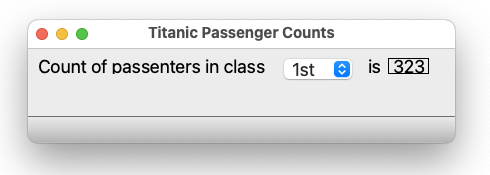
#### Write the Python code `TitanicWindow.py` containing class `TitanicWindow` that will load `titanic_window.ui` and populate the menu (a QComboBox component) named `class_menu` with menu items `1st`, `2nd`, and `3rd`. Whenever the user chooses a class by selecting a menu item, the application should query the **passenger** table for the count of passengers in the chosen class, and then display the count in the text box (a QLabel component) named `the_count`. The text box should initially display the count in first class, as shown above.
#### The cells below will create and start `TitanicWindow`. Remember that after the first run of the application, you may need to restart the Python kernel to run it again (from the Jupyter **Run** menu menu, select **Restart Kernel and Run All Cells ...**).

In [19]:
import sys
from PyQt5.QtWidgets import QApplication
from TitanicWindow import TitanicWindow

In [20]:
app = QApplication(sys.argv)
form = TitanicWindow()
app.exec_()

0